In [1]:
# Import Packages and setup
import os
import logging

import numpy as np

import scarlet
import scarlet.display
import scarlet.constraints as sc

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

In [2]:
# Load the sample images
path = os.path.abspath(os.path.join(os.path.dirname(scarlet.__file__),".."))
data = np.load(os.path.join(path, "data/test_sim/data.npz"))
images = data["images"]
filters = data["filters"]

from astropy.table import Table as ApTable
catalog = ApTable.read(os.path.join(path, "data/test_sim/true_catalog.fits"))
bg_rms = np.array([20]*len(images))

asinh = scarlet.display.Asinh(img=images, Q=50)

# Display the sources
def display_sources(sources, subset=None, combine=False, show_sed=True):
    """Display the data and model for all sources in a blend
    
    This convenience function is used to display all (or a subset) of
    the sources and (optionally) their SED's.
    """
    if subset is None:
        # Show all sources in the blend
        subset = range(len(sources))
    for m in subset:
        # Load the model for the source
        src = sources[m]
        model = src.get_model(combine=combine)
        # Since a model can be generated for each component in a source,
        # or all components can be combined into a single model,
        # reshape the model if there is only a single component
        if len(model.shape)==4:
            components = model.shape[0]
        else:
            model = np.expand_dims(model, axis=0)

        # Select the image patch the overlaps with the source and convert it to an RGB image
        img_rgb = scarlet.display.img_to_rgb(images[src.bb], filter_indices=[3,2,1], norm=asinh)

        # Build a model for each component in the model
        rgb = []
        for _model in model:
            # Convert the model to an RGB image
            _rgb = scarlet.display.img_to_rgb(_model, filter_indices=[3,2,1], norm=asinh)
            rgb.append(_rgb)

        # Display the image and model
        figsize = [6,3]
        columns = 2
        # Calculate the number of columns needed and shape of the figure
        if show_sed:
            figsize[0] += 3
            columns += 1
        if not combine:
            figsize[0] += 3*(model.shape[0]-1)
            columns += model.shape[0]-1
        # Build the figure
        fig = plt.figure(figsize=figsize)
        ax = [fig.add_subplot(1,columns,n+1) for n in range(columns)]
        ax[0].imshow(img_rgb)
        ax[0].set_title("Data")
        for n, _rgb in enumerate(rgb):
            ax[n+1].imshow(_rgb)
            if combine:
                ax[n+1].set_title("Initial Model")
            else:
                ax[n+1].set_title("Component {0}".format(n))
        if show_sed:
            for sed in src.sed:
                ax[-1].plot(sed)
            ax[-1].set_title("SED")
            ax[-1].set_xlabel("Band")
            ax[-1].set_ylabel("Intensity")
        # Mark the current source in the image
        y,x = src.center
        ax[0].plot(x-src.bb[2].start, y-src.bb[1].start, 'wx', mew=2)
        plt.tight_layout()
        plt.show()

In [16]:
sources = [scarlet.source.ExtendedSource((src['y'],src['x']), images, bg_rms, constraints=[sc.SmoothSymmetryConstraint(sigma=.01) & sc.PositivityConstraint() & sc.DirectMonotonicityConstraint()]) for src in catalog]

In [17]:
blend = scarlet.Blend(sources, images, bg_rms=bg_rms)
blend.fit(200)

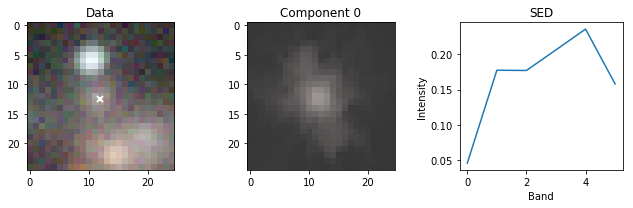

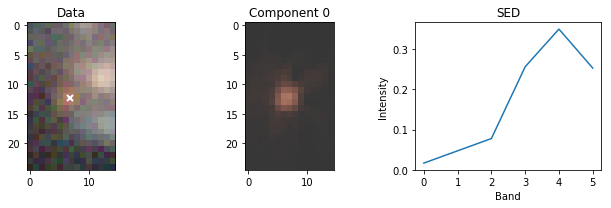

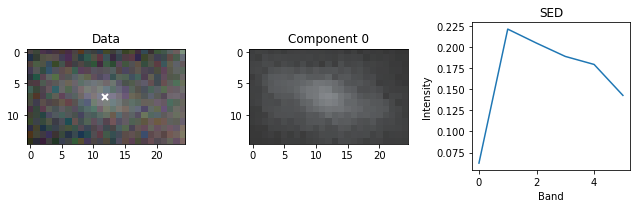

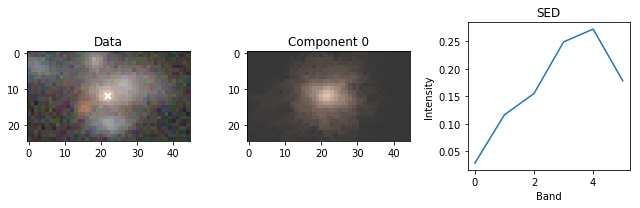

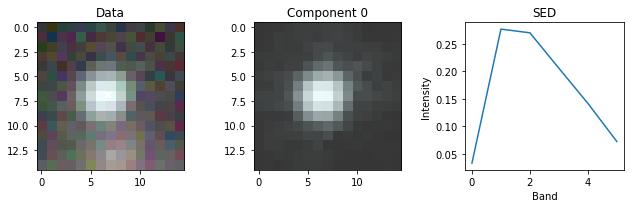

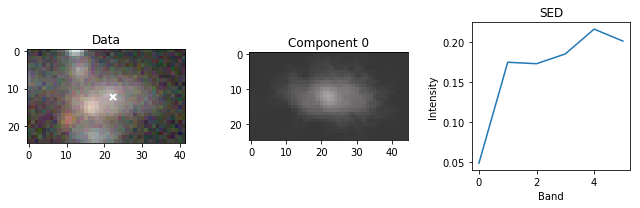

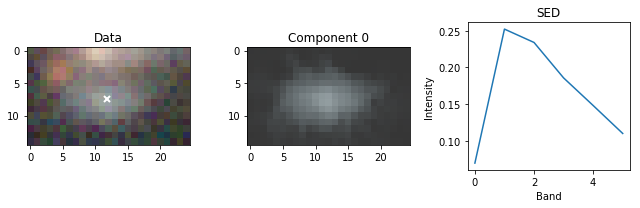

In [18]:
display_sources(sources)